<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/Update4_BTC_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

     |████████████████████████████████| 6.3 MB 28.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=4f96f9d7303c1c3c25fb982e56a42991524789ce13862975a1447ad861376d35
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Importing the Dataset & Exploring it

In [19]:
# Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '2y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: BTC-USD
You entered BTC-USD, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
718,2021-10-31,61850.488281,62406.171875,60074.328125,61318.957031,32241199927,0,0
719,2021-11-01,61320.449219,62419.003906,59695.183594,61004.406250,36150572843,0,0
720,2021-11-02,60963.253906,64242.792969,60673.054688,63226.402344,37746665647,0,0
721,2021-11-03,63254.335938,63516.937500,61184.238281,62970.046875,36124731509,0,0
722,2021-11-04,62941.804688,63123.289062,60799.664062,61452.230469,32615846901,0,0
723,2021-11-05,61460.078125,62541.468750,60844.609375,61125.675781,30605102446,0,0
724,2021-11-06,61068.875000,61590.683594,60163.781250,61527.480469,29094934221,0,0
725,2021-11-07,61554.921875,63326.988281,61432.488281,63326.988281,24726754302,0,0
726,2021-11-08,63344.066406,67673.742188,63344.066406,67566.828125,41125608330,0,0
727,2021-11-09,67380.914062,68530.335938,66469.273438,66584.320312,43658776576,0,0


In [20]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,728.000000,728.000000,728.000000,728.000000,7.280000e+02,728.0,728.0
mean,25975.283436,26712.439334,25200.485536,26052.451981,3.874493e+10,0.0,0.0
std,19097.125991,19669.253278,18480.746658,19146.279074,2.115591e+10,0.0,0.0
min,5002.578125,5331.833984,4106.980957,4970.788086,1.225260e+10,0.0,0.0
25%,9261.670410,9371.760254,9138.119141,9269.680908,2.477871e+10,0.0,0.0
50%,15572.805176,15909.849121,15258.423340,15640.594238,3.473853e+10,0.0,0.0
75%,43798.129883,45847.358398,42603.827148,43955.660156,4.676203e+10,0.0,0.0
max,67380.914062,68530.335938,66469.273438,67566.828125,3.509679e+11,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [21]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [22]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [23]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [24]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [25]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [26]:
hurst = []
lags = range(8, 81, 4)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst.append(hurst_exp)
px.line(hurst, x=lags, y=hurst, title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [27]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
723,2021-11-05,61125.675781
724,2021-11-06,61527.480469
725,2021-11-07,63326.988281
726,2021-11-08,67566.828125
727,2021-11-09,66584.320312


## Creating Facebook Prophet Model

In [28]:
m=Prophet(daily_seasonality=True)
m.fit(prophet_df)

##Forecasting

In [29]:
periods = 30
future=m.make_future_dataframe(periods)

In [30]:
forecast=m.predict(future)

In [31]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-11-09,11477.383499,7344.143545,13172.827760,11477.383499,11477.383499,-1189.926360,-1189.926360,-1189.926360,11106.056206,11106.056206,11106.056206,45.726113,45.726113,45.726113,-12341.708679,-12341.708679,-12341.708679,0.0,0.0,0.0,10287.457139
1,2019-11-10,11225.401958,6728.427408,12956.421270,11225.401958,11225.401958,-1260.120490,-1260.120490,-1260.120490,11106.056206,11106.056206,11106.056206,-20.703440,-20.703440,-20.703440,-12345.473255,-12345.473255,-12345.473255,0.0,0.0,0.0,9965.281468
2,2019-11-11,10973.420417,6740.872423,12830.775031,10973.420417,10973.420417,-1207.929626,-1207.929626,-1207.929626,11106.056206,11106.056206,11106.056206,5.722513,5.722513,5.722513,-12319.708345,-12319.708345,-12319.708345,0.0,0.0,0.0,9765.490791
3,2019-11-12,10721.438876,6341.445606,12490.116940,10721.438876,10721.438876,-1240.385483,-1240.385483,-1240.385483,11106.056206,11106.056206,11106.056206,-81.803620,-81.803620,-81.803620,-12264.638069,-12264.638069,-12264.638069,0.0,0.0,0.0,9481.053393
4,2019-11-13,10469.457335,6444.233337,12414.333769,10469.457335,10469.457335,-1053.064656,-1053.064656,-1053.064656,11106.056206,11106.056206,11106.056206,22.078375,22.078375,22.078375,-12181.199236,-12181.199236,-12181.199236,0.0,0.0,0.0,9416.392679
5,2019-11-14,10217.475794,6145.889194,11912.912721,10217.475794,10217.475794,-1034.512110,-1034.512110,-1034.512110,11106.056206,11106.056206,11106.056206,-69.558554,-69.558554,-69.558554,-12071.009762,-12071.009762,-12071.009762,0.0,0.0,0.0,9182.963684
6,2019-11-15,9965.494253,6077.696739,12300.906677,9965.494253,9965.494253,-731.724729,-731.724729,-731.724729,11106.056206,11106.056206,11106.056206,98.538614,98.538614,98.538614,-11936.319548,-11936.319548,-11936.319548,0.0,0.0,0.0,9233.769524
7,2019-11-16,9713.512712,5980.446790,12064.092626,9713.512712,9713.512712,-628.162629,-628.162629,-628.162629,11106.056206,11106.056206,11106.056206,45.726113,45.726113,45.726113,-11779.944948,-11779.944948,-11779.944948,0.0,0.0,0.0,9085.350083
8,2019-11-17,9461.531171,5794.643798,12093.008862,9461.531171,9461.531171,-519.835545,-519.835545,-519.835545,11106.056206,11106.056206,11106.056206,-20.703440,-20.703440,-20.703440,-11605.188310,-11605.188310,-11605.188310,0.0,0.0,0.0,8941.695626
9,2019-11-18,9209.549630,5803.534064,11961.460524,9209.549630,9209.549630,-303.965822,-303.965822,-303.965822,11106.056206,11106.056206,11106.056206,5.722513,5.722513,5.722513,-11415.744541,-11415.744541,-11415.744541,0.0,0.0,0.0,8905.583807


In [32]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

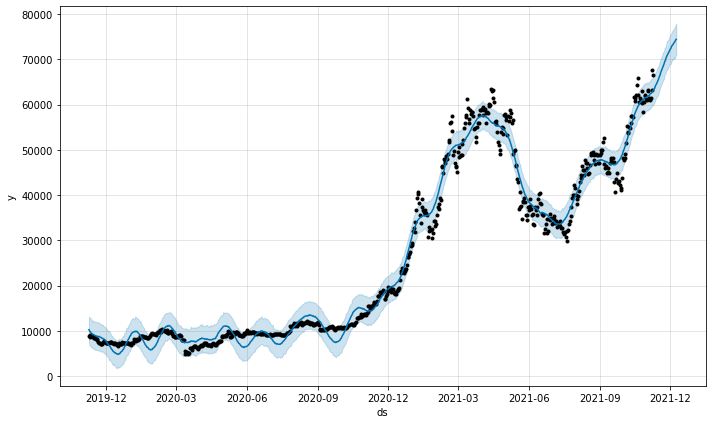

In [33]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

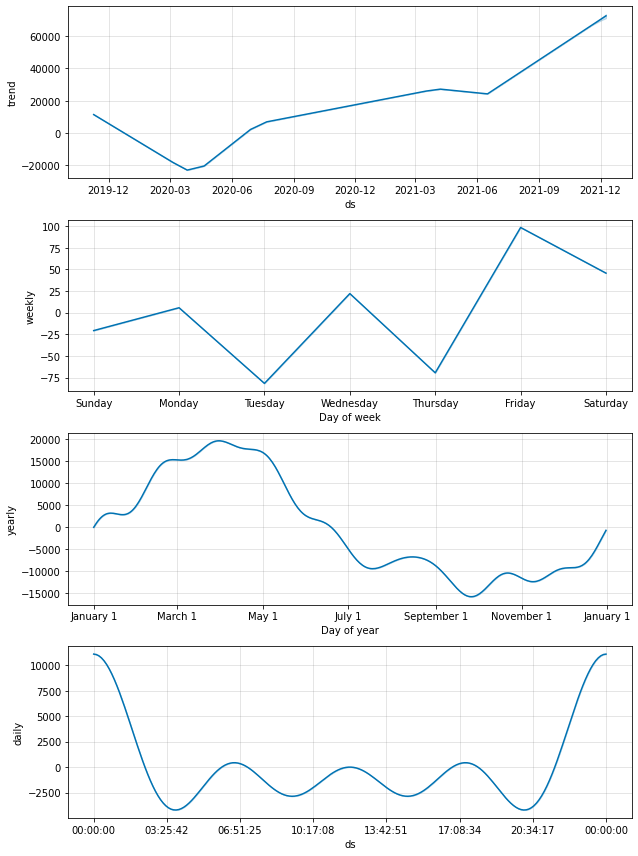

In [34]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [18]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>